# HDBSCAN Clustering + Advanced Retrieval (RAG-style) Assignment

This notebook has two parts:

**Part 1:** HDBSCAN Clustering — Deep Dive into Algorithm Internals  
**Part 2:** Advanced Retrieval Systems and RAG (Retrieval-Augmented Generation)



In [12]:
!pip -q install hdbscan umap-learn sentence-transformers faiss-cpu

In [13]:
import re
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import umap
import hdbscan
import faiss

from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

sns.set(style="whitegrid")
np.random.seed(42)

In [14]:
!pip -q install -U google-genai

from google.colab import userdata
from google import genai

api_key = userdata.get("GEMINI_API_KEY")
client = genai.Client(api_key=api_key)

models = list(client.models.list())
print("Number of models:", len(models))

for m in models[:30]:
    print(m.name)

Number of models: 54
models/embedding-gecko-001
models/gemini-2.5-flash
models/gemini-2.5-pro
models/gemini-2.0-flash-exp
models/gemini-2.0-flash
models/gemini-2.0-flash-001
models/gemini-2.0-flash-exp-image-generation
models/gemini-2.0-flash-lite-001
models/gemini-2.0-flash-lite
models/gemini-2.0-flash-lite-preview-02-05
models/gemini-2.0-flash-lite-preview
models/gemini-exp-1206
models/gemini-2.5-flash-preview-tts
models/gemini-2.5-pro-preview-tts
models/gemma-3-1b-it
models/gemma-3-4b-it
models/gemma-3-12b-it
models/gemma-3-27b-it
models/gemma-3n-e4b-it
models/gemma-3n-e2b-it
models/gemini-flash-latest
models/gemini-flash-lite-latest
models/gemini-pro-latest
models/gemini-2.5-flash-lite
models/gemini-2.5-flash-image-preview
models/gemini-2.5-flash-image
models/gemini-2.5-flash-preview-09-2025
models/gemini-2.5-flash-lite-preview-09-2025
models/gemini-3-pro-preview
models/gemini-3-flash-preview


In [15]:
from google.colab import userdata
from google import genai

api_key = userdata.get("GEMINI_API_KEY")
client = genai.Client(api_key=api_key)

MODEL_NAME = "models/gemini-2.5-flash"  # stable + fast (you have it)

resp = client.models.generate_content(
    model=MODEL_NAME,
    contents="Respond with exactly: OK"
)
print(resp.text)

OK


## Part 1: HDBSCAN Clustering — Deep Dive into Algorithm Internals

### 1.1 Load and Prepare the Dataset
We load the CSV and create a single text field by combining `title` and `content`.  
This is common in text clustering because titles are short but informative, while content provides additional context.

In [16]:
DATA_PATH = "/content/combined_data_environment.csv"

df = pd.read_csv(
    DATA_PATH,
    sep=";",
    encoding="latin1",
    engine="python",
    on_bad_lines="skip"
)

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()

Shape: (2969, 15)
Columns: ['title', 'publication_date', 'byline', 'content', 'subject', 'country', 'city', 'person', 'industry', 'company', 'word_count', 'publication_date_text', 'publication', 'author', 'copyright']


,title,publication_date,byline,content,subject,country,city,person,industry,company,word_count,publication_date_text,publication,author,copyright
0,Egypt at the forefront of developing green and...,01.01.22,NaN,Egypt at the forefront of developing green and...,"['GREEN FINANCE', 'BOND MARKETS', 'SUSTAINABLE...","['EGYPT', 'AFRICA', 'MIDDLE EAST', 'NORTHERN A...","['GLASGOW, SCOTLAND']",[],"['GREEN FINANCE', 'BOND MARKETS', 'SUSTAINABLE...",[],1827,Jan 22,['Euromoney'],NaN,Copyright 2022 Euromoney Institutional Investo...
1,"Inequality, climate change and economic recove...",29.11.21,FinTech Futures,"Inequality, climate change and economic recove...","['CLIMATE CHANGE', 'GREEN FINANCE', 'ECONOMIC ...","['AFRICA', 'SOUTH AFRICA', 'EASTERN AFRICA', '...",[],[],"['SIC6021 NATIONAL COMMERCIAL BANKS', 'GREEN F...",['AFRICAN DEVELOPMENT BANK GROUP'],699,"November 29, 2021 Monday",['Fintechfutures.com'],FinTech Futures,Copyright 2021 Informal PLC All Rights Reserved
2,11th UK-India Economic and Financial Dialogue ...,02.09.21,NaN,11th UK-India Economic and Financial Dialogue ...,"['PUBLIC FINANCE', 'COVID CORONAVIRUS', 'COVID...","['UNITED KINGDOM', 'INDIA', 'BRICS MEMBER STAT...","['LONDON, ENGLAND']",[],"['PUBLIC FINANCE AGENCIES & TREASURIES', 'TREA...",[],3560,"September 2, 2021 Thursday",['Impact News Service'],NaN,Copyright 2021 Impact Media Limited All Rights...
3,"""Being the Change We Want to See: A Sustainabl...",09.06.21,NaN,"""Being the Change We Want to See: A Sustainabl...","['SUSTAINABILITY', 'SUSTAINABLE DEVELOPMENT', ...","['SINGAPORE', 'ASIA', 'UNITED STATES']",[],[],"['SUSTAINABLE DEVELOPMENT', 'EMISSIONS', 'BANK...",[],3693,"June 9, 2021 Wednesday",['Singapore Government News'],NaN,"Copyright 2021 Singapore Government News, dist..."
4,Together we can mobilise capital and achieve n...,11.01.22,AXEL A. WEBER,Together we can mobilise capital and achieve n...,"['SUSTAINABLE DEVELOPMENT', 'AGREEMENTS', 'CLI...","['CHINA', 'UNITED STATES', 'ASIA', 'EUROPE']",[],[],"['SUSTAINABLE DEVELOPMENT', 'BANKING & FINANCE...",[],1004,"January 11, 2022 Tuesday",['The Australian'],AXEL A. WEBER,Copyright 2022 Nationwide News Pty Limited All...


In [17]:
def clean_text(x):
    x = "" if pd.isna(x) else str(x)
    x = re.sub(r"\s+", " ", x).strip()
    return x

df["title_clean"] = df["title"].apply(clean_text) if "title" in df.columns else ""
df["content_clean"] = df["content"].apply(clean_text) if "content" in df.columns else ""

df["text"] = (df["title_clean"] + ". " + df["content_clean"]).str.strip()
df = df[df["text"].str.len() > 30].copy()   # remove very tiny/empty rows
df = df.drop_duplicates(subset=["text"]).reset_index(drop=True)

print("After cleaning:", df.shape)
df[["title_clean","text"]].head()

After cleaning: (2856, 18)


,title_clean,text
0,Egypt at the forefront of developing green and...,Egypt at the forefront of developing green and...
1,"Inequality, climate change and economic recove...","Inequality, climate change and economic recove..."
2,11th UK-India Economic and Financial Dialogue ...,11th UK-India Economic and Financial Dialogue ...
3,"""Being the Change We Want to See: A Sustainabl...","""Being the Change We Want to See: A Sustainabl..."
4,Together we can mobilise capital and achieve n...,Together we can mobilise capital and achieve n...


### 1.2 Create Embeddings
HDBSCAN works on numeric vectors. For text, we first convert documents into dense vectors (“embeddings”).  
We use a pretrained `SentenceTransformer` model (`all-MiniLM-L6-v2`) because it is fast and works well for semantic similarity.

In [18]:

N = min(1000, len(df))
df_small = df.sample(n=N, random_state=42).reset_index(drop=True)

model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(df_small["text"].tolist(), show_progress_bar=True, normalize_embeddings=True)

embeddings = np.array(embeddings).astype("float32")
print("Embeddings shape:", embeddings.shape)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Embeddings shape: (1000, 384)


### 1.3 Dimensionality Reduction (UMAP)
HDBSCAN can work in high dimensions, but it often performs better after reducing dimensionality.
UMAP preserves local structure and helps clustering + visualization.

In [19]:
reducer = umap.UMAP(
    n_neighbors=15,
    n_components=5,   # 5D for clustering stability
    min_dist=0.0,
    metric="cosine",
    random_state=42
)

emb_umap = reducer.fit_transform(embeddings)
emb_umap = emb_umap.astype("float32")
print("UMAP shape:", emb_umap.shape)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP shape: (1000, 5)


### 1.4 Run HDBSCAN
HDBSCAN is a density-based clustering algorithm.
Key parameters:
- `min_cluster_size`: smallest cluster size allowed
- `min_samples`: how strict density should be (higher = more noise points)

In [20]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=15,
    min_samples=5,
    metric="euclidean",
    prediction_data=True
)

labels = clusterer.fit_predict(emb_umap)
df_small["cluster"] = labels

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = (labels == -1).sum()

print("Clusters found:", n_clusters)
print("Noise points:", n_noise)
df_small["cluster"].value_counts().head(10)

Clusters found: 16
Noise points: 276


,count
cluster,
-1,276
0,129
15,128
13,63
10,60
2,54
9,47
7,36
5,35


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


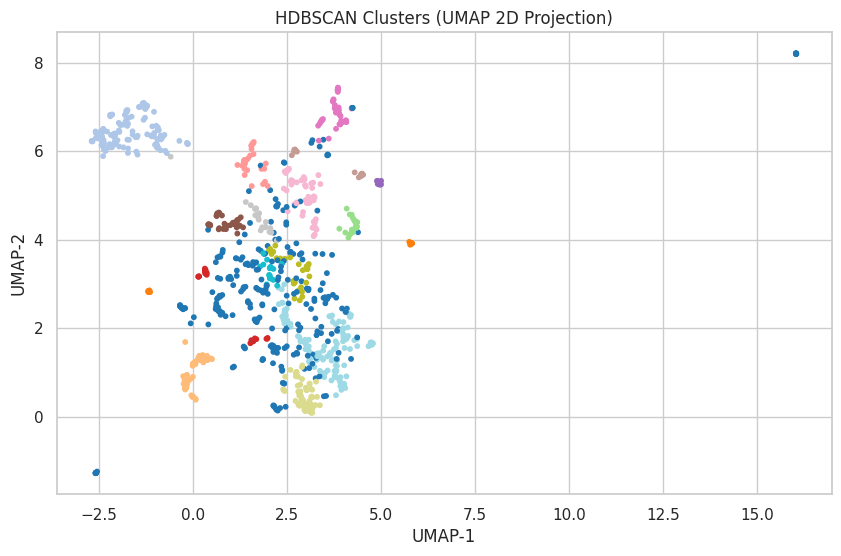

In [21]:
reducer_2d = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric="cosine", random_state=42)
emb_2d = reducer_2d.fit_transform(embeddings)

plt.figure(figsize=(10,6))
plt.scatter(emb_2d[:,0], emb_2d[:,1], c=labels, cmap="tab20", s=10)
plt.title("HDBSCAN Clusters (UMAP 2D Projection)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()

### 1.5 Algorithm Internals (Deep Dive)

HDBSCAN builds clusters using a density-based idea:

1. **Core distance**: distance from a point to its k-th nearest neighbor (controls local density).
2. **Mutual reachability distance** between points *a* and *b*:
   - max(core_dist(a), core_dist(b), dist(a,b))
   This makes sparse areas “farther apart” and dense areas “closer”.
3. Using mutual reachability, HDBSCAN constructs a **minimum spanning tree (MST)** and then forms a hierarchy.
4. Clusters are selected based on **stability** over different density levels (condensed tree).

Below we visualize the condensed tree which represents the cluster hierarchy and stability.

*Note on lambda:* In HDBSCAN plots, the condensed tree is often shown in terms of **lambda** (approximately \( \lambda = 1 / \text{distance} \)). As lambda increases, we move toward denser structure. Clusters that persist over larger lambda ranges are considered more stable and are selected by the algorithm.

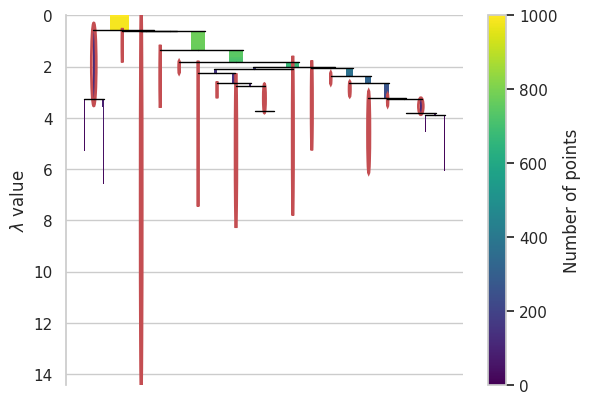

In [22]:
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
plt.show()

### 1.6 Core Distance and Mutual Reachability

To better understand HDBSCAN internals, I compute:

- **Core distance**: distance from each point to its k-th nearest neighbor (k is similar to `min_samples`).
- **Mutual reachability distance** between points a and b:

\[
d_{mr}(a,b) = \max(\text{core}_k(a), \text{core}_k(b), d(a,b))
\]

This transforms the space so sparse regions are pushed apart and dense regions are kept closer, which helps build the MST and cluster hierarchy.

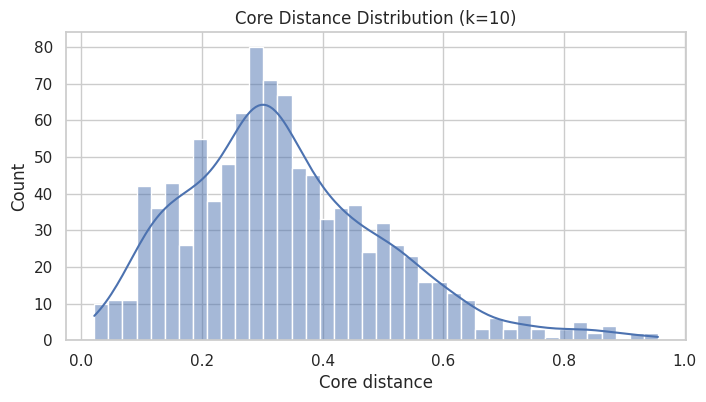

In [30]:
from sklearn.neighbors import NearestNeighbors

k = 10  # choose k close to min_samples (or a bit larger)
nbrs = NearestNeighbors(n_neighbors=k, metric="euclidean").fit(emb_umap)
distances, _ = nbrs.kneighbors(emb_umap)

core_dist = distances[:, -1]
df_small["core_dist"] = core_dist

plt.figure(figsize=(8,4))
sns.histplot(core_dist, bins=40, kde=True)
plt.title(f"Core Distance Distribution (k={k})")
plt.xlabel("Core distance")
plt.show()

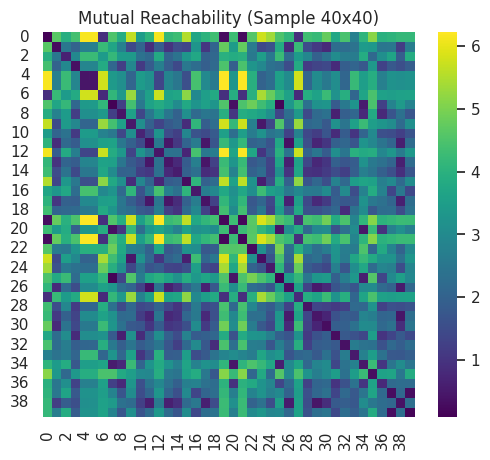

In [33]:
from sklearn.metrics import pairwise_distances

# sample for speed
sample_n = min(200, len(emb_umap))
idx = np.random.choice(len(emb_umap), size=sample_n, replace=False)

X = emb_umap[idx]
D = pairwise_distances(X, metric="euclidean")   # shape (n,n)

core_sample = core_dist[idx]                    # shape (n,)

# mutual reachability: max(D, core_i, core_j)
MR = np.maximum(D, core_sample[:, None])
MR = np.maximum(MR, core_sample[None, :])

plt.figure(figsize=(6,5))
sns.heatmap(MR[:40, :40], cmap="viridis")
plt.title("Mutual Reachability (Sample 40x40)")
plt.show()

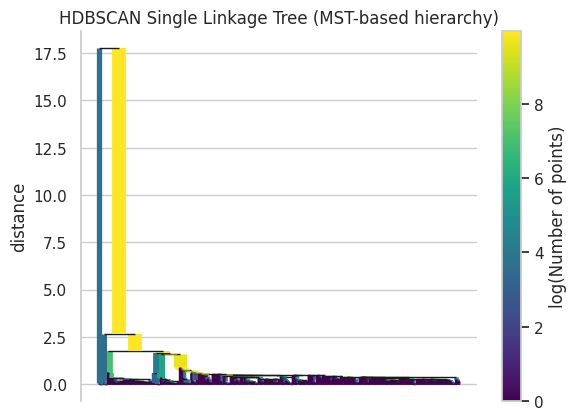

In [34]:
clusterer.single_linkage_tree_.plot(cmap="viridis", colorbar=True)
plt.title("HDBSCAN Single Linkage Tree (MST-based hierarchy)")
plt.show()

Cluster persistence: [0.19102271 0.08158609 0.53797576 0.14795025 0.02992273 0.23292677
 0.34523598 0.19002371 0.03756115 0.20433301 0.06246141 0.01450504
 0.02699712 0.09973987 0.00526044 0.03506226]


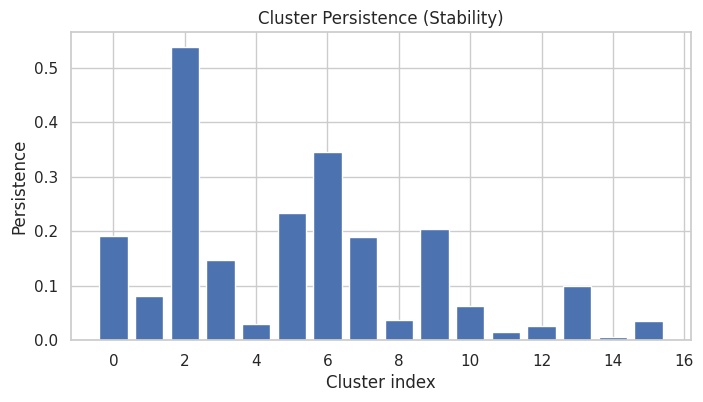

In [35]:
pers = clusterer.cluster_persistence_
print("Cluster persistence:", pers)

plt.figure(figsize=(8,4))
plt.bar(range(len(pers)), pers)
plt.title("Cluster Persistence (Stability)")
plt.xlabel("Cluster index")
plt.ylabel("Persistence")
plt.show()

### 1.7 Interpret Clusters (Top Keywords)
To understand what each cluster represents, we extract top TF‑IDF keywords from documents within each cluster.
This helps explain the “theme” of each group.

In [23]:
def top_keywords_for_cluster(texts, top_n=8):
    vec = TfidfVectorizer(stop_words="english", max_features=3000)
    X = vec.fit_transform(texts)
    avg = np.asarray(X.mean(axis=0)).ravel()
    idx = avg.argsort()[::-1][:top_n]
    return [vec.get_feature_names_out()[i] for i in idx]

clusters = sorted([c for c in df_small["cluster"].unique() if c != -1])

for c in clusters[:5]:  # show first 5 clusters (fast)
    texts_c = df_small.loc[df_small["cluster"] == c, "text"].tolist()
    print(f"\nCluster {c} | size={len(texts_c)}")
    print("Top keywords:", top_keywords_for_cluster(texts_c, top_n=10))
    print("Example title:", df_small.loc[df_small["cluster"] == c, "title_clean"].iloc[0])


Cluster 0 | size=129
Top keywords: ['sustainable', 'finance', 'uae', 'adgm', 'climate', 'financial', 'dhabi', 'abu', 'difc', 'sustainability']
Example title: ADIB Announces Associate Pathway Partnership with COP28

Cluster 1 | size=17
Top keywords: ['pnc', 'wells', 'fargo', 'sustainable', 'finance', 'environmental', '2018', 'loans', 'climate', 'low']
Example title: PNC Pledges $20 Billion In Environmental Finance

Cluster 2 | size=54
Top keywords: ['sustainable', 'canada', 'finance', 'climate', 'bmo', 'financial', 'panel', 'green', 'report', 'bank']
Example title: Canada's central climate bank; Terence corcoran

Cluster 3 | size=24
Top keywords: ['sustainable', 'finance', 'g20', 'india', 'ifsca', 'meeting', 'financial', 'global', 'ceew', 'climate']
Example title: International Financial Services Centres Authority (IFSCA) and Climate Policy Initiative sign MoU to cooperate on Sustainable Finance

Cluster 4 | size=23
Top keywords: ['sustainable', 'bbva', 'finance', 'bank', 'nordea', 'me

### 1.8 Hyperparameter Optimization (Mini Grid Search)

I test a small grid over (`min_cluster_size`, `min_samples`) and compare:
- number of clusters
- noise ratio
- mean persistence (stability)

This helps justify the final parameter choice.

In [29]:
grid_mcs = [10, 20, 40]
grid_ms = [1, 5, 10]

rows = []
for mcs in grid_mcs:
    for ms in grid_ms:
        c = hdbscan.HDBSCAN(min_cluster_size=mcs, min_samples=ms)
        lab = c.fit_predict(emb_umap)

        n_clusters = len(set(lab)) - (1 if -1 in lab else 0)
        noise_ratio = float(np.mean(lab == -1))
        mean_persist = float(np.mean(c.cluster_persistence_)) if len(c.cluster_persistence_) > 0 else 0.0

        rows.append({
            "min_cluster_size": mcs,
            "min_samples": ms,
            "n_clusters": n_clusters,
            "noise_ratio": noise_ratio,
            "mean_persistence": mean_persist
        })

grid_df = pd.DataFrame(rows).sort_values(["mean_persistence","noise_ratio"], ascending=[False, True])
grid_df

,min_cluster_size,min_samples,n_clusters,noise_ratio,mean_persistence
8,40,10,3,0.024,0.547167
7,40,5,3,0.041,0.492066
6,40,1,3,0.035,0.486318
5,20,10,3,0.024,0.361453
4,20,5,3,0.041,0.332771
2,10,10,20,0.321,0.137758
3,20,1,15,0.157,0.116233
1,10,5,30,0.242,0.114995
0,10,1,40,0.141,0.096752


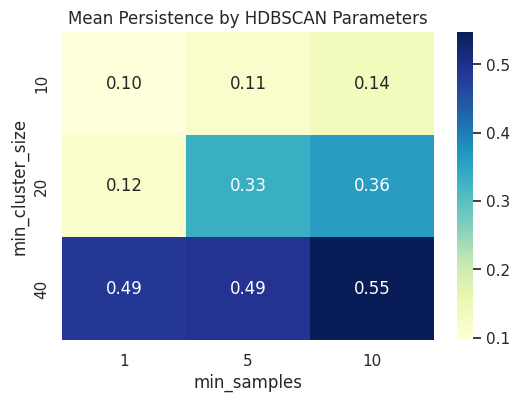

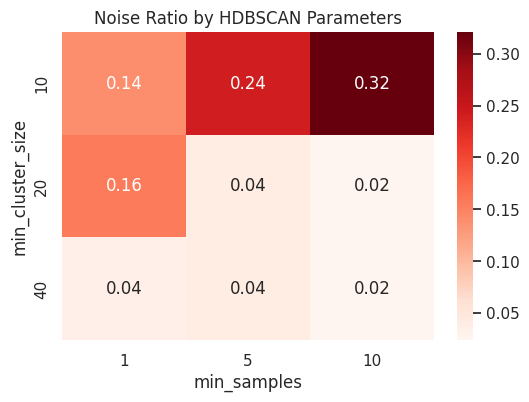

In [36]:
pivot_p = grid_df.pivot(index="min_cluster_size", columns="min_samples", values="mean_persistence")
plt.figure(figsize=(6,4))
sns.heatmap(pivot_p, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Mean Persistence by HDBSCAN Parameters")
plt.show()

pivot_n = grid_df.pivot(index="min_cluster_size", columns="min_samples", values="noise_ratio")
plt.figure(figsize=(6,4))
sns.heatmap(pivot_n, annot=True, fmt=".2f", cmap="Reds")
plt.title("Noise Ratio by HDBSCAN Parameters")
plt.show()

**Parameter choice (brief):**  
From the grid, I would select the configuration with relatively **high mean persistence** (stable clusters) while keeping the **noise ratio** reasonably low. In practice there is a trade-off: increasing `min_samples` often increases noise, while smaller `min_cluster_size` can create too many small clusters. I use these metrics to justify the final setting.

### 1.9 Limitations and Potential Improvements
- Results depend on the embedding model; different sentence-transformers could change cluster structure.
- UMAP parameters can strongly influence density structure; tuning `n_neighbors` and `min_dist` may improve separability.
- HDBSCAN can label many points as noise; this may be valid, but it can also indicate that the representation is not strongly clustered.
- Future work: try domain-specific embeddings, tune UMAP/HDBSCAN jointly, and manually evaluate cluster coherence with human inspection.

## Part 2: Advanced Retrieval Systems and RAG

In this section I implement:
1) **Hybrid Search** (BM25 + semantic vector search)  
2) **Cross-Encoder Reranking** (two-stage retrieval)  
3) **RAG with Citations** using Gemini (LLM + retrieved evidence)

In [24]:
!pip -q install rank-bm25 sentence-transformers faiss-cpu

In [43]:
def chunk_text(text, chunk_size=350, overlap=80):
    words = str(text).split()
    if len(words) < 40:
        return []
    chunks = []
    step = chunk_size - overlap
    for i in range(0, len(words), step):
        ch = " ".join(words[i:i+chunk_size])
        if len(ch.split()) >= 40:
            chunks.append(ch)
    return chunks

# Use your df (or df_small) depending on what you used for clustering
# For speed, we use a subset
N_DOCS = min(600, len(df))
df_rag = df.sample(N_DOCS, random_state=42).reset_index(drop=True).copy()

# Build a single text field
df_rag["title_clean"] = df_rag["title"].fillna("").astype(str)
df_rag["content_clean"] = df_rag["content"].fillna("").astype(str)
df_rag["text"] = (df_rag["title_clean"] + ". " + df_rag["content_clean"]).str.strip()

chunks, meta = [], []
for doc_id, row in df_rag.reset_index(drop=True).iterrows():
    doc_chunks = chunk_text(row["text"])
    for chunk_id, ch in enumerate(doc_chunks):
        chunks.append(ch)
        meta.append({"doc_id": doc_id, "chunk_id": chunk_id, "title": row["title_clean"]})

print("Docs used:", len(df_rag))
print("Total chunks:", len(chunks))
print("Example chunk:\n", chunks[0][:400])

Docs used: 600
Total chunks: 2553
Example chunk:
 ADIB Announces Associate Pathway Partnership with COP28. ADIB Announces Associate Pathway Partnership with COP28 Abu Dhabi Islamic Bank (ADIB) has announced its partnership as an Associate Pathway Partner of the 28th United Nations Climate Change Conference (COP28). ADIB will showcase how financial institutions can enable progress toward sustainability goals and support the UAE's development as a 


### 2.2 Build Vector Index (FAISS)
We embed each chunk and store the vectors in a FAISS index.  
FAISS allows fast approximate nearest neighbor search (vector similarity search).

In [26]:
chunk_emb = model.encode(chunks, show_progress_bar=True, normalize_embeddings=True)
chunk_emb = np.array(chunk_emb).astype("float32")

dim = chunk_emb.shape[1]
index = faiss.IndexFlatIP(dim)   # inner product (works with normalized embeddings = cosine similarity)
index.add(chunk_emb)

print("FAISS index size:", index.ntotal)

Batches:   0%|          | 0/80 [00:00<?, ?it/s]

FAISS index size: 2553


### 2.3 Hybrid Search (BM25 + Semantic)
We combine lexical BM25 and semantic vector search by normalizing both scores and using a weighted sum (alpha).

BM25 is strong for exact keyword matches (names, specific terms), while semantic search is strong when wording differs but meaning is similar. Hybrid search combines both signals and usually improves robustness across different query types.

In [37]:
!pip -q install rank-bm25
from rank_bm25 import BM25Okapi

tokenized_corpus = [c.lower().split() for c in chunks]
bm25 = BM25Okapi(tokenized_corpus)

def normalize_scores(arr):
    arr = np.array(arr, dtype=float)
    if arr.max() == arr.min():
        return np.zeros_like(arr)
    return (arr - arr.min()) / (arr.max() - arr.min())

def hybrid_retrieve(query, k=10, alpha=0.6):
    # semantic
    q_emb = model.encode([query], normalize_embeddings=True).astype("float32")
    sem_scores, sem_idxs = index.search(q_emb, k)
    sem_scores, sem_idxs = sem_scores[0], sem_idxs[0]

    # bm25
    bm_scores_all = bm25.get_scores(query.lower().split())

    sem_norm = normalize_scores(sem_scores)
    bm_norm_all = normalize_scores(bm_scores_all)

    combined = []
    for s_norm, idx in zip(sem_norm, sem_idxs):
        comb = alpha * s_norm + (1 - alpha) * bm_norm_all[idx]
        combined.append((float(comb), int(idx)))

    combined.sort(reverse=True, key=lambda x: x[0])
    top = combined[:k]

    return [(score, idx, meta[idx], chunks[idx]) for score, idx in top]

q = "green bonds climate finance"
hyb = hybrid_retrieve(q, k=5, alpha=0.6)
for score, idx, m, ch in hyb:
    print("\nHybrid:", round(score,3), "| cite:", f"[{m['doc_id']}:{m['chunk_id']}]")
    print("Title:", m["title"][:80])
    print(ch[:250])


Hybrid: 0.932 | cite: [100:0]
Title: The time for European green bonds
The time for European green bonds. The time for European green bonds With COP28 having passed, conveying a certain sense of hope and bringing with it progress and marked signals for investors on the importance of sustainable finance and the progress 

Hybrid: 0.823 | cite: [61:1]
Title: Canada : Canada issues inaugural green bond
we continue our governments record investments in climate action, leveraging private investment will help us meet Canadas 2030 emissions reduction target and achieve net-zero emissions by 2050. The Honourable Chrystia Freeland, Deputy Prime Minister 

Hybrid: 0.817 | cite: [586:1]
Title: Ravi Menon: What we need to do to make green finance work
through financing transition activities and channelling capital to environmentally friendly projects and technologies. The good news is that the volume of assets invested in sustainable projects is rising rapidly. Approximately one-fifth of all asse

### 2.4 Cross-Encoder Reranking (Two-Stage Retrieval)
We rerank the hybrid results using a cross-encoder that scores (query, chunk) pairs more accurately.

Cross-encoders are slower than bi-encoders because they score each (query, passage) pair directly, but they typically improve relevance. This is why reranking is applied only to a small candidate set returned by the first-stage retriever.

In [38]:
from sentence_transformers import CrossEncoder
cross_encoder = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")

def rerank_with_cross_encoder(query, retrieved, top_k=5):
    pairs = [(query, r[3]) for r in retrieved]
    ce_scores = cross_encoder.predict(pairs)

    reranked = []
    for (hyb_score, idx, m, ch), ce in zip(retrieved, ce_scores):
        reranked.append((float(ce), float(hyb_score), idx, m, ch))

    reranked.sort(reverse=True, key=lambda x: x[0])
    return reranked[:top_k]

reranked = rerank_with_cross_encoder(q, hyb, top_k=5)

print("BEFORE (Hybrid order):")
for score, idx, m, ch in hyb:
    print(f"  {score:.3f} -> [{m['doc_id']}:{m['chunk_id']}] {m['title'][:60]}")

print("\nAFTER (Cross-Encoder order):")
for ce, hyb_score, idx, m, ch in reranked:
    print(f"  CE={ce:.3f} (hyb={hyb_score:.3f}) -> [{m['doc_id']}:{m['chunk_id']}] {m['title'][:60]}")

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

BEFORE (Hybrid order):
  0.932 -> [100:0] The time for European green bonds
  0.823 -> [61:1] Canada : Canada issues inaugural green bond
  0.817 -> [586:1] Ravi Menon: What we need to do to make green finance work
  0.799 -> [159:0] GREEN BONDS - Africa embraces sustainable finance to fight c
  0.311 -> [240:2] SEB's The Green Bond: whyåÊthe war in Ukraine may accelerate

AFTER (Cross-Encoder order):
  CE=7.308 (hyb=0.823) -> [61:1] Canada : Canada issues inaugural green bond
  CE=7.123 (hyb=0.799) -> [159:0] GREEN BONDS - Africa embraces sustainable finance to fight c
  CE=5.676 (hyb=0.932) -> [100:0] The time for European green bonds
  CE=4.787 (hyb=0.311) -> [240:2] SEB's The Green Bond: whyåÊthe war in Ukraine may accelerate
  CE=4.340 (hyb=0.817) -> [586:1] Ravi Menon: What we need to do to make green finance work


### 2.5 Temporal Search
Some queries are time-sensitive. I add a simple **time-decay weighting** so that more recent documents are boosted.

I compare:
- **Filtering**: only search documents after a cutoff date
- **Decay**: keep all documents but reweight scores by recency

In [44]:
# --- Temporal preprocessing ---
df_rag["publication_date"] = pd.to_datetime(df_rag["publication_date"], errors="coerce")
max_date = df_rag["publication_date"].max()
print("Max publication_date:", max_date)

def time_decay_weight(pub_date, max_date, half_life_days=365):
    """
    Exponential half-life decay:
    weight = 0.5^(age_days / half_life_days)
    """
    if pd.isna(pub_date) or pd.isna(max_date):
        return 1.0
    age_days = (max_date - pub_date).days
    return float(0.5 ** (age_days / half_life_days))

# Precompute weights per doc_id for speed
doc_time_weight = {}
for doc_id, row in df_rag.reset_index(drop=True).iterrows():
    doc_time_weight[doc_id] = time_decay_weight(row["publication_date"], max_date, half_life_days=365)

def apply_temporal_decay(results, half_life_days=365):
    adjusted = []
    for score, idx, m, ch in results:
        w = doc_time_weight.get(m["doc_id"], 1.0)
        adjusted.append((score * w, idx, m, ch, w))
    adjusted.sort(reverse=True, key=lambda x: x[0])
    return adjusted

# --- Demo: compare hybrid vs temporal-decay hybrid ---
query_time = "latest policy updates on sustainable finance"
hyb_base = hybrid_retrieve(query_time, k=8, alpha=0.6)
hyb_time = apply_temporal_decay(hyb_base, half_life_days=365)

print("\nBASE HYBRID (no time):")
for score, idx, m, ch in hyb_base[:5]:
    doc_date = df_rag.loc[m["doc_id"], "publication_date"]
    print(f"  {score:.3f} [{m['doc_id']}:{m['chunk_id']}] date={doc_date} title={m['title'][:60]}")

print("\nTEMPORAL-DECAY HYBRID:")
for score_adj, idx, m, ch, w in hyb_time[:5]:
    doc_date = df_rag.loc[m["doc_id"], "publication_date"]
    print(f"  {score_adj:.3f} (w={w:.2f}) [{m['doc_id']}:{m['chunk_id']}] date={doc_date} title={m['title'][:60]}")

Max publication_date: 2024-12-01 00:00:00

BASE HYBRID (no time):
  0.840 [587:0] date=2021-06-21 00:00:00 title=SUSTAINABLE FINANCE SURGES DESPITE VOLATILE MARKETS DURING C
  0.717 [364:3] date=2019-06-16 00:00:00 title=Canada's financial markets are stunting our growth and under
  0.559 [320:0] date=2021-07-07 00:00:00 title=Strategy for Financing the Transition to a Sustainable Econo
  0.527 [8:0] date=2022-03-03 00:00:00 title=Insider launches Financing a Sustainable Future editorial se
  0.476 [252:6] date=2019-03-22 00:00:00 title=Remarks by Vice-President Valdis Dombrovskis at the High-lev

TEMPORAL-DECAY HYBRID:
  0.078 (w=0.15) [8:0] date=2022-03-03 00:00:00 title=Insider launches Financing a Sustainable Future editorial se
  0.077 (w=0.09) [587:0] date=2021-06-21 00:00:00 title=SUSTAINABLE FINANCE SURGES DESPITE VOLATILE MARKETS DURING C
  0.053 (w=0.09) [320:0] date=2021-07-07 00:00:00 title=Strategy for Financing the Transition to a Sustainable Econo
  0.016 (w=0.02) [364:3

/tmp/ipython-input-1038651351.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_rag["publication_date"] = pd.to_datetime(df_rag["publication_date"], errors="coerce")


In [45]:
cutoff = max_date - pd.Timedelta(days=365*2)  # last 2 years
allowed_docs = set(df_rag.index[df_rag["publication_date"] >= cutoff].tolist())

def hybrid_retrieve_filtered(query, k=10, alpha=0.6):
    # get more than k then filter down
    raw = hybrid_retrieve(query, k=50, alpha=alpha)
    filtered = [(s, idx, m, ch) for (s, idx, m, ch) in raw if m["doc_id"] in allowed_docs]
    return filtered[:k]

hyb_filtered = hybrid_retrieve_filtered(query_time, k=5, alpha=0.6)
print("\nFILTERED (last 2 years):")
for score, idx, m, ch in hyb_filtered:
    doc_date = df_rag.loc[m["doc_id"], "publication_date"]
    print(f"  {score:.3f} [{m['doc_id']}:{m['chunk_id']}] date={doc_date} title={m['title'][:60]}")


FILTERED (last 2 years):
  0.521 [92:1] date=2023-11-22 00:00:00 title=SEB's The Green Bond report: stall warning
  0.429 [385:1] date=2024-09-01 00:00:00 title=Sustainable Finance Market Forecast: Green Bonds Lead the Wa
  0.366 [459:0] date=2022-12-07 00:00:00 title=#NAME?
  0.327 [212:0] date=2023-08-18 00:00:00 title=Global Sustainable Finance Market Size Expected to Grow Over
  0.299 [267:0] date=2023-10-28 00:00:00 title=Swaminathan J: Fostering economic growth through sustainable


### 2.6 RAG Pipeline with Citations (Gemini)
We pass the top reranked chunks into Gemini and force citations in the format [doc_id:chunk_id].

In [46]:
def build_context_from_reranked(reranked_results, max_chars=6000):
    blocks, total = [], 0
    for ce, hyb_score, idx, m, ch in reranked_results:
        cite = f"[{m['doc_id']}:{m['chunk_id']}]"
        block = f"{cite}\n{ch}"
        if total + len(block) > max_chars:
            break
        blocks.append(block)
        total += len(block)
    return "\n\n---\n\n".join(blocks)

def gemini_rag(question, reranked_results):
    context = build_context_from_reranked(reranked_results)
    prompt = f"""
Answer the question using ONLY the context below.

Rules:
- If the context is insufficient, say: "I cannot answer from the provided documents."
- Every factual claim must end with a citation like [doc_id:chunk_id].
- Do not invent citations.

QUESTION:
{question}

CONTEXT:
{context}
""".strip()

    resp = client.models.generate_content(
        model=MODEL_NAME,
        contents=prompt
    )
    return resp.text

def full_rag_pipeline(question, alpha=0.6, k_retrieve=10, k_rerank=5):
    retrieved = hybrid_retrieve(question, k=k_retrieve, alpha=alpha)
    reranked = rerank_with_cross_encoder(question, retrieved, top_k=k_rerank)
    answer = gemini_rag(question, reranked)
    return answer, reranked

questions = [
    "What does the dataset report about green bonds or green bond issuance?",
    "What challenges are discussed about sustainable finance or climate finance?",
    "What examples of climate-related initiatives are mentioned?"
]

for q in questions:
    ans, src = full_rag_pipeline(q)
    print("\n" + "="*80)
    print("Q:", q)
    print("A:", ans)

    print("\nTop evidence chunks shown to the LLM:")
    for ce, hyb_score, idx, m, ch in src:
        print(f" - [{m['doc_id']}:{m['chunk_id']}] {m['title'][:80]}")


Q: What does the dataset report about green bonds or green bond issuance?
A: The dataset reports several aspects about green bonds and green bond issuance:

*   There is a clear disparity between total issuance and the amount of new investment that can be tracked within green-bond reporting practices, indicating a need for significant improvements in market transparency and timely disclosure of use of proceeds [doc_151:4].
*   Green-bond issuance is expected to reach a record of $250 billion this year, up from $170.9 billion last year [doc_151:4]. However, sustainable finance heads suggest this funding is not financing new green projects that would not have been financed otherwise [doc_151:4].
*   Bankers describe green bonds as "conventional bonds relabeled, re-batched" that are "not moving the needle at all" and question their "additionality," suggesting many companies would have received funding for their efforts anyway [doc_151:4].
*   The amount of green-bond issuance in emerging

### 2.7 Baseline Semantic Retrieval (FAISS Top-k)
This is a baseline semantic search system using FAISS only. Later sections add BM25 hybrid search and cross-encoder reranking.

In [47]:
def retrieve(query, k=5):
    q_emb = model.encode([query], normalize_embeddings=True).astype("float32")
    scores, idxs = index.search(q_emb, k)
    results = []
    for score, idx in zip(scores[0], idxs[0]):
        results.append((float(score), meta[idx], chunks[idx]))
    return results

query = "green finance and renewable energy projects"
results = retrieve(query, k=5)

for score, m, ch in results:
    print("\nScore:", round(score, 3), "| doc:", m["doc_id"], "| chunk:", m["chunk_id"])
    print("Title:", m["title"][:120])
    print("Chunk preview:", ch[:400])


Score: 0.742 | doc: 64 | chunk: 2
Title: Council of the European Union: Green Finance - Background paper for the informal lunchtime discussion on 17 October 2016
Chunk preview: Green Economy Process, which will create a space for open discussion and a wide exchange of views and experiences on how to initiate a new era of transformation to an economy that respects the environment and the social aspects of development. Financial market participants are quick to point out that policy signals, in particular in the form of a carbon price or tax that correctly reflects externa

Score: 0.692 | doc: 586 | chunk: 1
Title: Ravi Menon: What we need to do to make green finance work
Chunk preview: through financing transition activities and channelling capital to environmentally friendly projects and technologies. The good news is that the volume of assets invested in sustainable projects is rising rapidly. Approximately one-fifth of all assets worldwide are now in funds that use some form of ESG 